<a href="https://colab.research.google.com/github/JaiswalRohit13/MinorProject1/blob/main/latest_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Thu Dec  8 18:28:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [4]:
from tensorflow import keras

### Load Base Model

In [5]:
base_model = keras.applications.InceptionV3(
                    weights='imagenet',
                    input_shape=(224, 224, 3),
                    include_top=False)

87910968/87910968 [==============================] - 3s 0us/step


In [6]:
# Freeze base model
base_model.trainable = False

### Add layers to model

In [7]:
inputs = keras.Input(shape = (224, 224, 3))

x = base_model(inputs)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='relu')(x)

outputs = keras.layers.Dense(6, activation='softmax')(x)

model = keras.Model(inputs, outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 22,854,950
Trainable params: 1,052,166
Non-trainable params: 21,802,784
_________________________________________

In [9]:
model.compile(loss = keras.losses.CategoricalCrossentropy(),
              metrics = keras.metrics.CategoricalAccuracy())

### Augment the data

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(samplewise_center=True,
    rotation_range=10,
    zoom_range=0.1, 
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    horizontal_flip=True,  
    vertical_flip=True)

test_gen = ImageDataGenerator(samplewise_center=True)

In [11]:
train = train_gen.flow_from_directory(
    '/content/drive/MyDrive/MINOR PROJECT DATASET/dataset/train',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical")


test = test_gen.flow_from_directory(
    '/content/drive/MyDrive/MINOR PROJECT DATASET/dataset/test',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical")

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [12]:
train.class_indices

{'freshapples': 0,
 'freshbanana': 1,
 'freshoranges': 2,
 'rottenapples': 3,
 'rottenbanana': 4,
 'rottenoranges': 5}

### Inspect the data

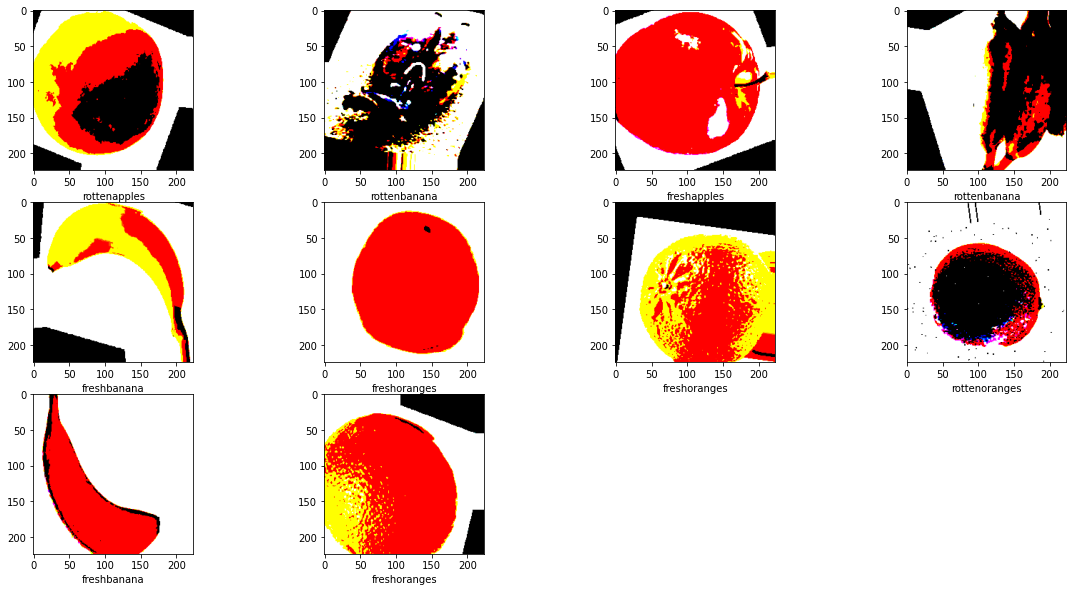

In [13]:
import matplotlib.pyplot as plt
# Encode the classes
classes = train.class_indices
classes = {indx: c for c, indx in classes.items()}


#PLotting some images 
images, labels=train.next()
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i])
    #plt.axis('off')
    plt.xlabel(classes[np.argmax(labels[i])])

### Fitting the model

In [14]:
callbacks = keras.callbacks.EarlyStopping(patience = 2, monitor='val_loss')


model.fit(train,
          validation_data = test,
          steps_per_epoch = train.samples/train.batch_size,
          validation_steps= test.samples/test.batch_size,
          epochs=8,
          callbacks= [callbacks])

Epoch 1/8
340/340 [==============================] - 4996s 15s/step - loss: 15.6193 - categorical_accuracy: 0.3790 - val_loss: 2.1584 - val_categorical_accuracy: 0.5044
Epoch 2/8
340/340 [==============================] - 189s 556ms/step - loss: 2.6503 - categorical_accuracy: 0.4540 - val_loss: 2.4770 - val_categorical_accuracy: 0.4199
Epoch 3/8
340/340 [==============================] - 188s 553ms/step - loss: 1.4727 - categorical_accuracy: 0.5166 - val_loss: 1.2508 - val_categorical_accuracy: 0.5082
Epoch 4/8
340/340 [==============================] - 190s 557ms/step - loss: 1.1753 - categorical_accuracy: 0.5669 - val_loss: 1.3062 - val_categorical_accuracy: 0.5271
Epoch 5/8
340/340 [==============================] - 190s 557ms/step - loss: 1.0949 - categorical_accuracy: 0.5917 - val_loss: 0.9866 - val_categorical_accuracy: 0.6427
Epoch 6/8
340/340 [==============================] - 190s 559ms/step - loss: 1.0852 - categorical_accuracy: 0.6000 - val_loss: 0.9009 - val_categorical_acc

### Fine tune all layers of the model

In [15]:
# Unfreeze the base model
base_model.trainable = True

# Compile the model with a low learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-5),
               loss=keras.losses.CategoricalCrossentropy(),
               metrics=[keras.metrics.CategoricalAccuracy()])

In [16]:
model.fit(train,
          validation_data= test,
          steps_per_epoch= train.samples/train.batch_size,
          validation_steps= test.samples/test.batch_size,
          epochs=5)

Epoch 1/5
340/340 [==============================] - 222s 625ms/step - loss: 1.0787 - categorical_accuracy: 0.5788 - val_loss: 0.2569 - val_categorical_accuracy: 0.9689
Epoch 2/5
340/340 [==============================] - 208s 609ms/step - loss: 0.1770 - categorical_accuracy: 0.9679 - val_loss: 0.0453 - val_categorical_accuracy: 0.9904
Epoch 3/5
340/340 [==============================] - 208s 611ms/step - loss: 0.0747 - categorical_accuracy: 0.9818 - val_loss: 0.0165 - val_categorical_accuracy: 0.9970
Epoch 4/5
340/340 [==============================] - 208s 611ms/step - loss: 0.0373 - categorical_accuracy: 0.9919 - val_loss: 0.0096 - val_categorical_accuracy: 0.9970
Epoch 5/5
340/340 [==============================] - 207s 607ms/step - loss: 0.0261 - categorical_accuracy: 0.9935 - val_loss: 0.0050 - val_categorical_accuracy: 0.9996


# Saving the model as a h5 file

In [22]:
from tensorflow.keras.models import load_model

model.save('model_inception.h5')

### Evaluating

In [17]:
model.evaluate(test, steps= test.samples/test.batch_size)

84/84 [==============================] - 17s 203ms/step - loss: 0.0050 - categorical_accuracy: 0.9996


[0.004978945478796959, 0.9996293783187866]

### Make a pipline for easy use

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing import image as image_utils


def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)
    


def pipe_line(image_path): 
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    final_pred = classes[np.argmax(preds)]
    return final_pred

1/1 [==============================] - 0s 25ms/step


'rottenoranges'

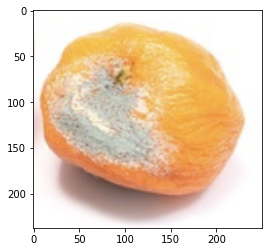

In [21]:
path = '/content/drive/MyDrive/MINOR PROJECT DATASET/dataset/test/rottenoranges/Screen Shot 2018-06-12 at 11.31.39 PM.png'
pipe_line(path)